In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import corner
from numpy.polynomial.chebyshev import Chebyshev
import os
from scipy.ndimage import uniform_filter1d

In [ ]:
# Define the path to the allStar catalog
allstar_file = 'lab2_data/allStar-dr17-synspec_rev1.fits'

# Open the FITS file and read the data
with fits.open(allstar_file) as hdulist:
    data = Table(hdulist[1].data)

In [ ]:
# List of fields of interest
fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']

# Filter data based on the 'FIELD' column
data_filtered = data[np.isin(data['FIELD'], fields)]

# Create a mask for entries with all required labels present
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
mask = np.ones(len(data_filtered), dtype=bool)
for label in labels:
    mask &= ~np.isnan(data_filtered[label])

data_filtered = data_filtered[mask]

# Apply SNR >= 50 cut
data_filtered = data_filtered[data_filtered['SNR'] >= 50]

# Exclude stars with LOGG > 4 or TEFF > 5700 K
data_filtered = data_filtered[(data_filtered['LOGG'] <= 4) & (data_filtered['TEFF'] <= 5700)]

# Exclude stars with FE_H < -1
data_filtered = data_filtered[data_filtered['FE_H'] >= -1]

print(f"Total number of stars: {len(data_filtered)}")

# Save the filtered Astropy Table to a FITS file
data_filtered.write('lab2_data/filtered_training_set.fits', overwrite=True)

print("Filtered Astropy Table saved to 'lab2_data/filtered_training_set.fits'")

In [2]:
def load_filtered_training_set(filepath='lab2_data/filtered_training_set.fits'):
    data_filtered = Table.read(filepath)
    return data_filtered

data_filtered = load_filtered_training_set()

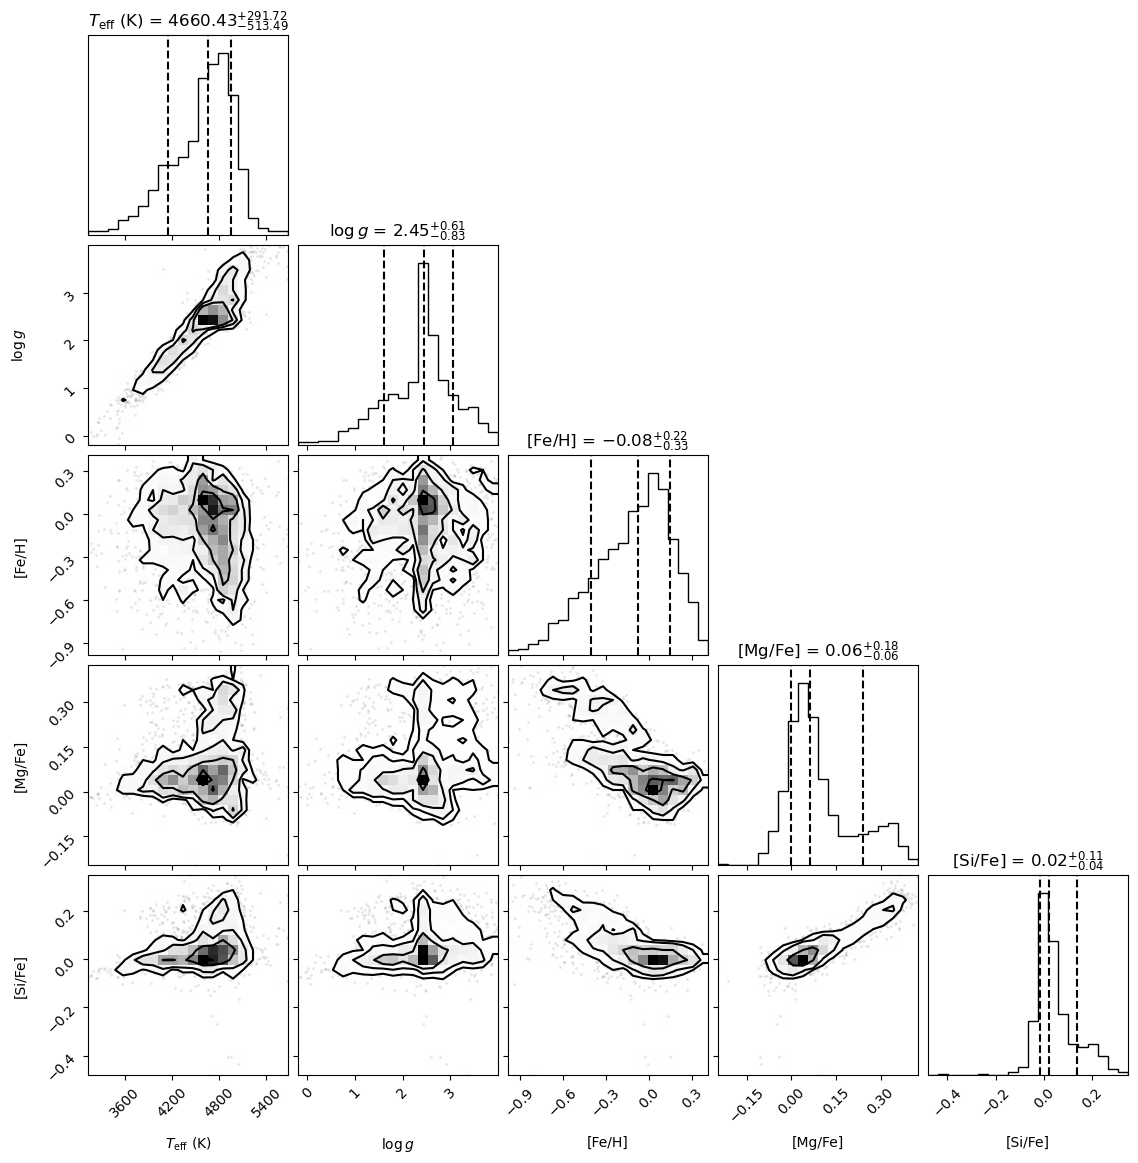

In [3]:
# Extract the labels for plotting
labels_to_plot = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
label_data = np.vstack([data_filtered[label] for label in labels_to_plot]).T

# Define labels for the plot
plot_labels = [r'$T_{\mathrm{eff}}$ (K)', r'$\log g$', r'[Fe/H]', r'[Mg/Fe]', r'[Si/Fe]']

# Create the corner plot
figure = corner.corner(
    label_data,
    labels=plot_labels,
    show_titles=True,
    title_fmt='.2f',
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12}
)
plt.show()

In [26]:
# # Define the base URLs
# aspcap_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1"
# apstar_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars"

# # Extract the relevant columns from the filtered data
# apogee_ids = data_filtered['APOGEE_ID']
# telescopes = data_filtered['TELESCOPE']
# fields = data_filtered['FIELD']

# # Define the folder to save the spectra
# output_folder = "lab2_data/apStar_spectra"
# os.makedirs(output_folder, exist_ok=True)

# # Function to download a file from a given URL
# def download_spectra(url, filename):
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(filename, 'wb') as file:
#             file.write(response.content)
#         print(f"Downloaded: {filename}")
#     else:
#         print(f"Failed to download: {url}")

# # Loop over the filtered data and construct the URLs
# for apogee_id, telescope, field in zip(apogee_ids, telescopes, fields):
#     # Construct the apStar file URL
#     apstar_url = f"{apstar_base_url}/{telescope}/{field}/apStar-dr17-{apogee_id}.fits"
#     apstar_filename = os.path.join(output_folder, f"apStar-dr17-{apogee_id}.fits")
    
#     # Download the apStar file
#     download_spectra(apstar_url, apstar_filename)

Flux shape before processing: (4, 8575)
Flux shape after flattening: (8575,)


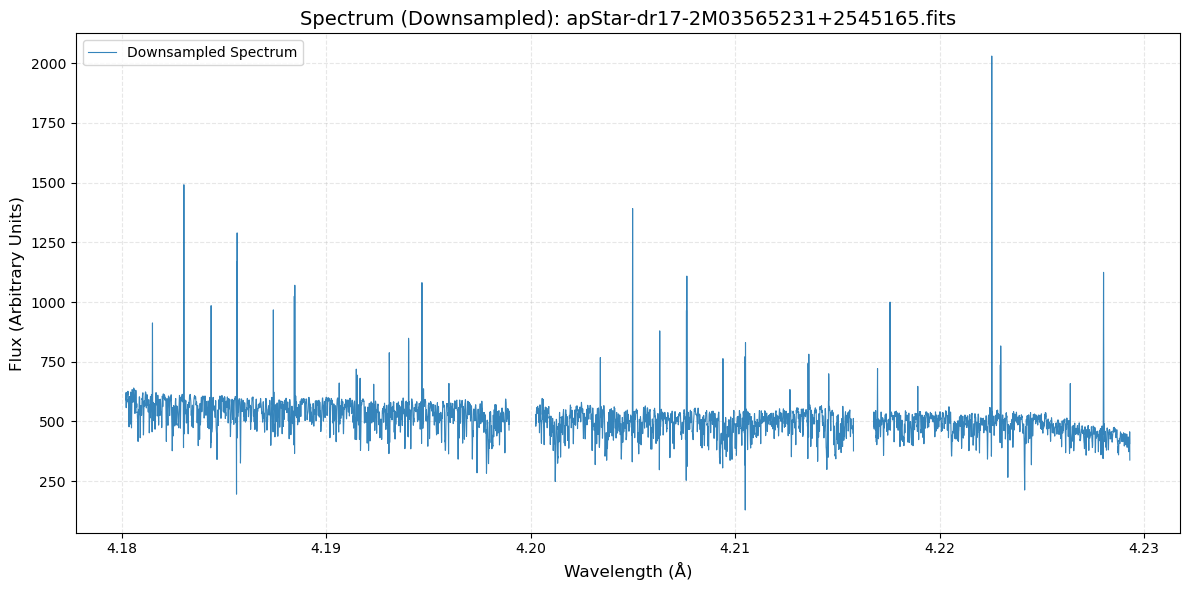

In [95]:
output_folder = "lab2_data/apStar_spectra"
downloaded_files = os.listdir(output_folder)

def plot_apstar_spectrum(apstar_filename, downsample_factor=1):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux (multi-visit spectrum)
        flux = hdulist[1].data  # Coadded flux data is in the second HDU
        header = hdulist[1].header  # Header contains necessary metadata
        
        # Debug: Check the shape of flux
        print("Flux shape before processing:", flux.shape)
        
        # Handle multi-dimensional flux data
        if flux.ndim > 1:
            # Option 1: Flatten the flux array
            # flux = flux.flatten()
            # Option 2: Select a specific spectrum
            flux = flux[0]  # Uncomment and adjust index if needed
            print("Flux shape after flattening:", flux.shape)
        
        # Reconstruct the wavelength array
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)     # Number of flux points (pixels)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Downsample the data by averaging over groups of points
        downsampled_wavelength = wavelength[::downsample_factor]
        downsampled_flux = flux[::downsample_factor]

        # Plot downsampled flux vs wavelength
        plt.figure(figsize=(12, 6))
        plt.plot(downsampled_wavelength, downsampled_flux, label='Downsampled Spectrum', 
                 color='#1f77b4', linewidth=0.8, alpha=0.9)
        
        # Enhance the plot
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
        plt.title(f'Spectrum (Downsampled): {os.path.basename(apstar_filename)}', fontsize=14)
        plt.legend(fontsize=10)
        
        # Add grid for better readability
        plt.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()

apstar_file_path = os.path.join(output_folder, downloaded_files[0])
plot_apstar_spectrum(apstar_file_path)


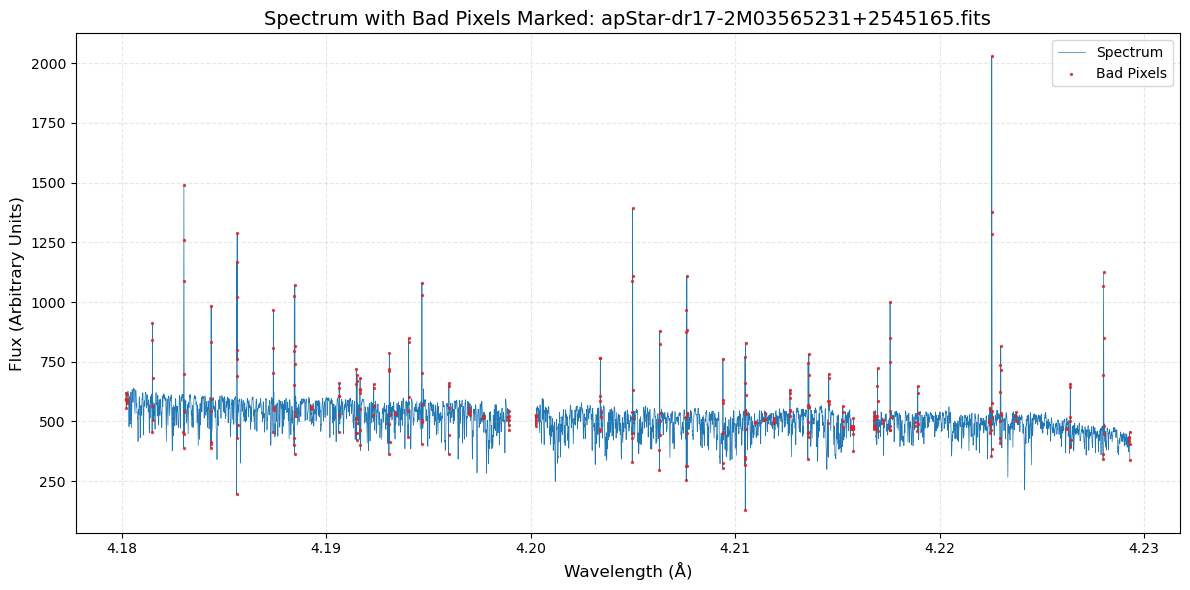

In [96]:
def process_spectrum_with_bitmask(apstar_filename, large_error_value=1e10):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux, error (uncertainty), and mask (bitmask)
        flux = hdulist[1].data  # Coadded flux data
        error = hdulist[2].data  # Uncertainty (error) array
        bitmask = hdulist[3].data  # Bitmask array
        
        # Handle multi-dimensional flux data if necessary
        if flux.ndim > 1:
            # flux = flux.flatten()
            # error = error.flatten()
            # bitmask = bitmask.flatten()
            flux = flux[0]
            error = error[0]
            bitmask = bitmask[0]

        # Define the bits we're interested in (bit positions for BADPIX, CRPIX, SATPIX, etc.)
        bad_bits_mask = (
            (bitmask & (1 << 0)) |   # BADPIX
            (bitmask & (1 << 1)) |   # CRPIX
            (bitmask & (1 << 2)) |   # SATPIX
            (bitmask & (1 << 3)) |   # UNFIXABLE
            (bitmask & (1 << 4)) |   # BADDARK
            (bitmask & (1 << 5)) |   # BADFLAT
            (bitmask & (1 << 6)) |   # BADERR
            (bitmask & (1 << 7)) |   # NOSKY
            (bitmask & (1 << 12))    # SIG_SKYLINE
        )
        
        # Identify bad pixels (where any of the relevant bits are set)
        bad_pixel_mask = bad_bits_mask > 0
        
        # Set uncertainty of bad pixels to a large value
        error[bad_pixel_mask] = large_error_value

        # Reconstruct the wavelength array from the header
        header = hdulist[1].header
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Plot the spectrum (flux) first
        plt.figure(figsize=(12, 6))
        
        plt.plot(wavelength, flux, label='Spectrum', color='#1f77b4', linewidth=0.5, zorder=1)
        plt.scatter(wavelength[bad_pixel_mask], flux[bad_pixel_mask], color='#d62728', s=2, label='Bad Pixels', zorder=2, alpha=0.8)
        
        # Set labels and title
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
        plt.title(f'Spectrum with Bad Pixels Marked: {os.path.basename(apstar_filename)}', fontsize=14)
        
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3, linestyle='--')
    
        
        plt.tight_layout()
        plt.show()


        # Return processed flux, error, and bad pixel mask
        return flux, error, bad_pixel_mask

# Example usage: Process the first apStar file and plot the results
apstar_file_path = os.path.join(output_folder, downloaded_files[0])
flux, error, bad_pixel_mask = process_spectrum_with_bitmask(apstar_file_path)


In [90]:
# Count the number of bad bits (bad pixels)
num_bad_bits = np.sum(bad_pixel_mask)

# Print the result
print(f"Number of bad bits (bad pixels): {num_bad_bits}")


Number of bad bits (bad pixels): 331


Spectrum wavelength range: 15100.80 Å - 16949.86 Å
Continuum wavelength range: 15170.85 Å - 16930.43 Å

Processing Chip 1:
Wavelength range: 15140 Å - 15810 Å
Number of pixels in chip: 3134
Number of continuum points in chip: 241
Median flux for Chip 1: 512.59
Chebyshev fit successful for Chip 1.

Processing Chip 2:
Wavelength range: 15860 Å - 16430 Å
Number of pixels in chip: 2556
Number of continuum points in chip: 108
Median flux for Chip 2: 460.03
Chebyshev fit successful for Chip 2.

Processing Chip 3:
Wavelength range: 16470 Å - 16950 Å
Number of pixels in chip: 2079
Number of continuum points in chip: 180
Median flux for Chip 3: 435.52
Chebyshev fit successful for Chip 3.


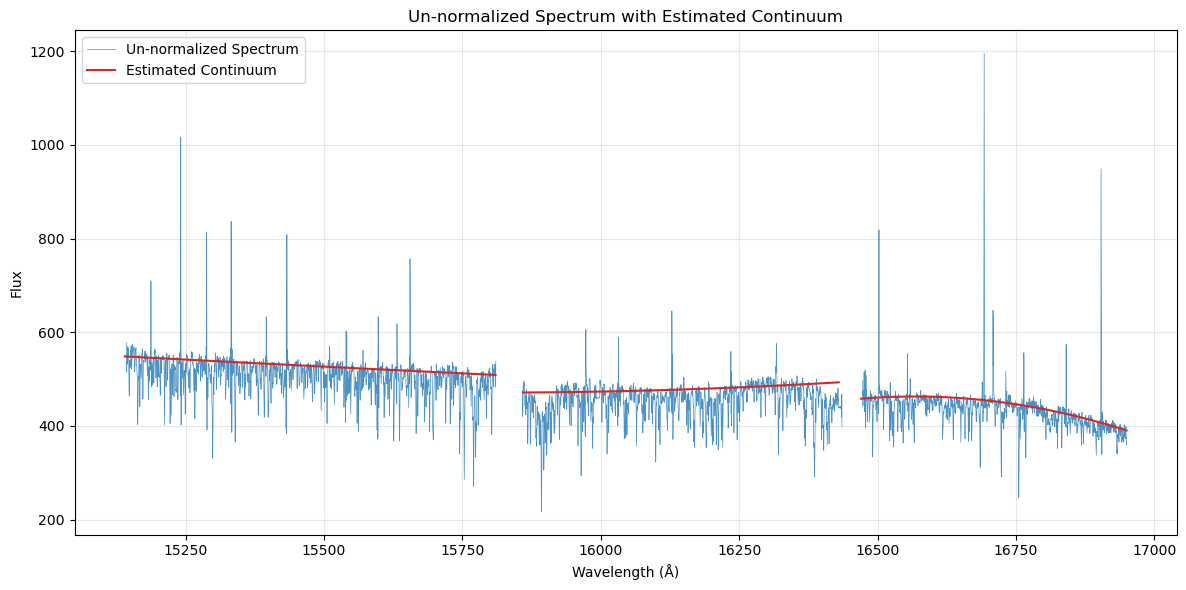

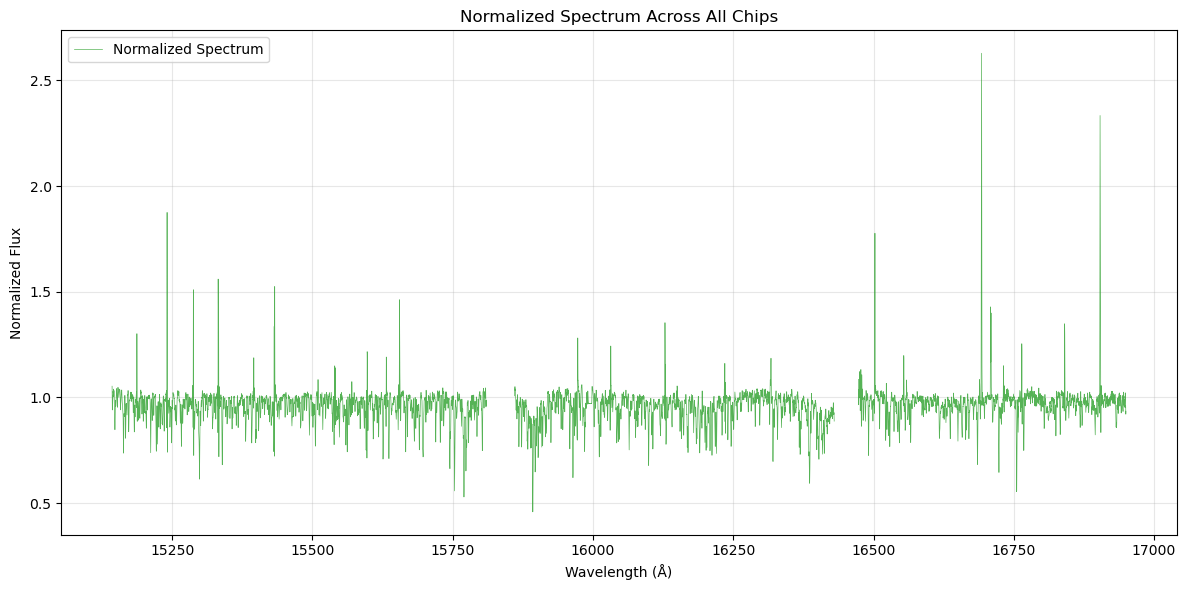

In [92]:
def load_continuum_pixels(filename):
    """Load the continuum wavelengths from the provided file."""
    continuum_data = np.load(filename)
    # Extract wavelengths that are marked as trusted
    continuum_wavelengths = continuum_data['wavelengths'][continuum_data['trusted']]
    return continuum_wavelengths

def find_closest_indices(spectrum_wavelengths, target_wavelengths):
    """Find indices in spectrum_wavelengths closest to each target_wavelength."""
    indices = np.searchsorted(spectrum_wavelengths, target_wavelengths)
    indices = np.clip(indices, 1, len(spectrum_wavelengths) - 1)
    left = spectrum_wavelengths[indices - 1]
    right = spectrum_wavelengths[indices]
    indices -= (np.abs(target_wavelengths - left) < np.abs(target_wavelengths - right))
    return indices

def running_median(flux, window_size=50):
    """Compute running median using a window of specified size."""
    return uniform_filter1d(flux, size=window_size, mode='nearest')

def normalize_spectrum(apstar_filename, continuum_pixels_filename):
    # Load the continuum wavelengths
    continuum_wavelengths = load_continuum_pixels(continuum_pixels_filename)
    
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract flux data and header
        flux_data = hdulist[1].data  # Flux data, possibly multi-dimensional
        header = hdulist[1].header

        # Handle multi-dimensional flux data
        if flux_data.ndim == 2:
            # Multiple chips, use all data
            flux = flux_data.flatten()
        else:
            raise ValueError("Unexpected flux data dimensions")
        
        # Reconstruct the logarithmic wavelength array
        crval = header['CRVAL1']  # Starting log10(wavelength)
        cdelt = header['CDELT1']  # Delta log10(wavelength)
        num_pixels = flux.size
        logwavelength = crval + cdelt * np.arange(num_pixels)
        wavelength = 10 ** logwavelength

    # **Limit the wavelength and flux arrays to the range up to 16950 Å**
    max_wavelength = 16950  # End of Chip 3
    valid_mask = wavelength <= max_wavelength
    wavelength = wavelength[valid_mask]
    flux = flux[valid_mask]

    # Print wavelength ranges
    print(f"Spectrum wavelength range: {wavelength.min():.2f} Å - {wavelength.max():.2f} Å")
    print(f"Continuum wavelength range: {continuum_wavelengths.min():.2f} Å - {continuum_wavelengths.max():.2f} Å")

    # Initialize arrays to hold the normalized flux and continuum
    normalized_flux = np.zeros_like(flux)
    continuum = np.zeros_like(flux)

    # Define the wavelength ranges for each chip – changed from Ness et al 2015 (based on the plot)
    chip_wavelength_ranges = [
        (15140, 15810),  # Chip 1
        (15860, 16430),  # Chip 2
        (16470, 16950)   # Chip 3
    ]

    # Process each chip separately
    for chip_idx, (chip_min_wave, chip_max_wave) in enumerate(chip_wavelength_ranges):
        # Identify the indices in the wavelength array for this chip
        chip_mask = (wavelength >= chip_min_wave) & (wavelength <= chip_max_wave)
        chip_wavelength = wavelength[chip_mask]
        chip_flux = flux[chip_mask]

        # Continuum points in this chip
        chip_cont_mask = (continuum_wavelengths >= chip_min_wave) & (continuum_wavelengths <= chip_max_wave)
        chip_cont_wavelength = continuum_wavelengths[chip_cont_mask]
        # Find closest indices for continuum wavelengths within the chip
        if len(chip_cont_wavelength) >= 1:
            continuum_indices = find_closest_indices(chip_wavelength, chip_cont_wavelength)
            continuum_indices = np.clip(continuum_indices, 0, len(chip_wavelength) - 1)
            chip_cont_flux = chip_flux[continuum_indices]

            # Exclude NaN values in chip_cont_flux
            valid_continuum = ~np.isnan(chip_cont_flux)
            chip_cont_wavelength = chip_cont_wavelength[valid_continuum]
            chip_cont_flux = chip_cont_flux[valid_continuum]
        else:
            chip_cont_flux = np.array([])
            chip_cont_wavelength = np.array([])

        print(f"\nProcessing Chip {chip_idx + 1}:")
        print(f"Wavelength range: {chip_min_wave} Å - {chip_max_wave} Å")
        print(f"Number of pixels in chip: {len(chip_wavelength)}")
        print(f"Number of continuum points in chip: {len(chip_cont_wavelength)}")

        # Handle NaNs in chip_flux
        chip_flux_no_nan = chip_flux[~np.isnan(chip_flux)]
        if len(chip_flux_no_nan) == 0:
            median_flux = 1.0  # Default value
            print(f"All flux values in Chip {chip_idx + 1} are NaN. Setting continuum to 1.0")
            continuum_chip = np.ones_like(chip_flux)
        else:
            median_flux = np.nanmedian(chip_flux_no_nan)
            print(f"Median flux for Chip {chip_idx + 1}: {median_flux:.2f}")

            # Fit polynomial if enough points, else use running median
            if len(chip_cont_wavelength) >= 3:
                try:
                    cheb_fit = Chebyshev.fit(chip_cont_wavelength, chip_cont_flux, deg=2)
                    continuum_chip = cheb_fit(chip_wavelength)
                    # Check for NaNs in continuum_chip
                    if np.isnan(continuum_chip).any():
                        print(f"Chebyshev fit resulted in NaNs in Chip {chip_idx + 1}. Using running median flux.")
                        continuum_chip = running_median(chip_flux, window_size=50)
                    else:
                        print(f"Chebyshev fit successful for Chip {chip_idx + 1}.")
                except Exception as e:
                    print(f"Chebyshev fit failed for Chip {chip_idx + 1} with error: {e}. Using running median flux.")
                    continuum_chip = running_median(chip_flux, window_size=50)
            else:
                print(f"Insufficient continuum points in Chip {chip_idx + 1}. Using running median flux.")
                continuum_chip = running_median(chip_flux, window_size=50)

        # Assign the continuum for this chip
        continuum[chip_mask] = continuum_chip

    # **Ensure that the continuum is non-zero within the valid range**
    zero_continuum_mask = (continuum == 0)
    if np.any(zero_continuum_mask):
        continuum[zero_continuum_mask] = np.nan

    # Normalize the flux by dividing by the estimated continuum
    normalized_flux = flux / continuum
    
    # Plotting the Continuum
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength, flux, label='Un-normalized Spectrum', color='#1f77b4', alpha=0.8, linewidth=0.5)
    plt.plot(wavelength, continuum, label='Estimated Continuum', color='#d62728', alpha=1, linewidth=1.5)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Un-normalized Spectrum with Estimated Continuum')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plotting the Normalized Flux
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength, normalized_flux, label='Normalized Spectrum', color='#2ca02c', alpha=0.8, linewidth=0.5)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Normalized Flux')
    plt.title('Normalized Spectrum Across All Chips')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return normalized_flux

output_folder = 'lab2_data/apStar_spectra' 
downloaded_files = os.listdir(output_folder)
if not downloaded_files:
    print(f"No files found in the directory {output_folder}")
else:
    apstar_file_path = os.path.join(output_folder, downloaded_files[2])  
    continuum_pixels_file_path = 'lab2_data/cannon_continuum_apogee.npz' 
    normalized_flux = normalize_spectrum(apstar_file_path, continuum_pixels_file_path)